Class labels [1 2 3]
Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


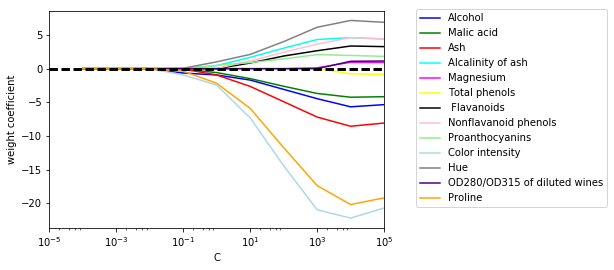

In [3]:
import pandas as pd
from io import StringIO
import numpy as np

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df.isnull()
df.isnull().sum()
df.isnull().sum(1)
df.isnull().sum(0)

df.values
df.dropna()
df.dropna(axis=1)
df
df.dropna(axis=0)
df.dropna(how='all')
df.dropna(thresh=4)
df.dropna(subset=['C'])

import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data=imr.transform(df.values)

imr2 = Imputer(missing_values='NaN', strategy='median', axis=0)
imputed_data2=imr2.fit(df).transform(df.values)
imputed_data2
imr2 = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imr3 = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputed_data3=imr3.fit(df).transform(df.values)
imputed_data3
df = pd.DataFrame([
['green', 'M', 10.1, 'class1'],
['red', 'L', 13.5, 'class2'],
['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df
size_mapping = {'XL':3, 'L': 2, 'M':1}
df['size'] = df['size'].map(size_mapping)
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping
df['size'].map(inv_size_mapping)

class_mapping  = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping
df['classlabel'] = df['classlabel'].map(class_mapping)
df
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y
class_le.inverse_transform(y)
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0]  = color_le.fit_transform(X[:, 0])
X
from sklearn.preprocessing import OneHotEncoder
ohe= OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()
X
ohe.fit_transform(X)
pd.get_dummies(df[['price', 'color', 'size']])
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns
df_wine.columns = [ 'Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', ' Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df_wine.iloc[0, 0]
df_wine.iloc[:, 0]
df_wine.iloc[:, 1]

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1', C=0.1)

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
lr.intercept_
lr.coef_
import matplotlib.pyplot as plt
fig=plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4,6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],label=df_wine.columns[column+1], color=color)
    
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03),ncol=1, fancybox=True)
plt.show()

    

In [20]:
# Sequential Backward Selection (SBS)
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,test_size=0.25, random_state=1):  
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=self.test_size,random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)

        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    


<function accuracy_score at 0x10d2de620>


In [22]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

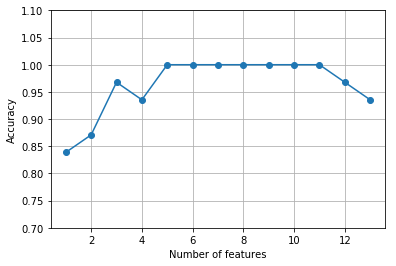

In [24]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [42]:
print('index,    # of features,    indeces')
n=5
for i, _ in enumerate(sbs.subsets_):
    print(i, len(_), _)
    if len(_)==n:
        indx=i
        break
print(indx)
k5 = list(sbs.subsets_[indx])
print(df_wine.columns[1:][k5])


index,    # of features,    indeces
0 13 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
1 12 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12)
2 11 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12)
3 10 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12)
4 9 (0, 1, 2, 3, 6, 7, 8, 10, 12)
5 8 (0, 1, 2, 3, 6, 8, 10, 12)
6 7 (0, 1, 3, 6, 8, 10, 12)
7 6 (0, 1, 3, 6, 10, 12)
8 5 (0, 1, 3, 10, 12)
8
Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [51]:
knn.fit(X_train_std, y_train)
print('#--> knn using all the features')
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

knn.fit(X_train_std[:, k5], y_train)
print('\n#--> knn using five features')
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))


#--> knn using all the features
Training accuracy: 0.983870967742
Test accuracy: 0.944444444444

#--> knn using five features
Training accuracy: 0.959677419355
Test accuracy: 0.962962962963
